### First attempt at VMC
Using Variational Monte Carlo to find the ground state of a particle with potential $V(x) =\frac{1}{2} m\omega^2x^2 + \lambda x^4$.

We want to minimize the expected ground state energy:
$$\varepsilon = \frac{\int dX \, \psi^\dagger(X)\hat{H}\psi(X)}{\int dX\, \psi^\dagger(X) \psi(X)} = \frac{\int dX \, \psi^2(X)\psi^{-1}(X)\hat{H}\psi(X)}{\int dX\, \psi^2(X)}$$


In [4]:
import numpy as np
from matplotlib import pyplot as plt
import random
import sympy as sym

# constants for the potential
m = 1
omega = 1
lam = .2
hbar = 1
N = 10**4


x = sym.Symbol('x')
a = sym.Symbol('a')

sym_psi = sym.exp(-a*x**2)
sym_ddpsi = sym.diff(sym.diff(sym_psi, x), x)
partial_a = sym.diff(sym.log(sym_psi),a)
grad_log_psi = sym.lambdify([x,a], partial_a)

# potential function
def V(x_inp):
    return 1/2*m * omega**2 * x_inp**2 + lam * x_inp**4

psi = sym.lambdify([x, a], sym_psi, dummify=True)
ddpsi = sym.lambdify([x, a], sym_ddpsi, dummify=True)

def Hpsi(x_inp,a):
    return V(x_inp) * psi(x_inp, a)  -hbar**2 / (2*m) * ddpsi(x_inp, a)

# function that samples the probability distribution P, n times
# uses the metropolis algorithm
# for any more than n=1, returns an array
def sample(a, n = 1):
    outputs = []
    # pick the start point
    x_t = 0
    for t in range(n):
        x_prime = x_t + random.uniform(-1,1)
        
        if (random.uniform(0,1) < psi(x_prime, a)**2/psi(x_t, a)**2):
            x_t = x_prime
        outputs.append(x_t)
    if n == 1:
        return outputs[0]
    return outputs


# now we define the approximation of the average, which uses the metropolis sampling
def avg_energy(N, a):
    # get N sampled points
    samples = sample(a, N)
    # apply the function to every point
    applied = [(1/psi(x_a, a) * Hpsi(x_a,a)) for x_a in samples]
    return 1/N * sum(applied)

# definition of the gradient
def gradient(a_inp, N):
    samples = sample(a_inp, N)
    energy_exp = 1/N * sum([(1/psi(x_a, a_inp) * Hpsi(x_a, a_inp)) for x_a in samples])
    gradlogpsi_exp = 1/N * sum([grad_log_psi(x_a, a_inp) for x_a in samples], 0)
    both_exp = 1/N * sum([(1/psi(x_a, a_inp) * grad_log_psi(x_a, a_inp) * Hpsi(x_a, a_inp)) for x_a in samples], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

# define the gradient descent algorithm
def grad_opt(a_0, lr, max_iterations=10000, tolerance=.001, N=10**4):
    a = a_0
    hist = []
    for _ in range(max_iterations):
        # gradient in this case is just a number
        diff = lr * gradient(a, N)
        #print(diff)
        if abs(diff) < tolerance:
            return a
        a = a - diff
        hist.append(a)
    return a



In [5]:
a_vals = np.linspace(.1, 2, 30)
energies = [avg_energy(N, a) for a in a_vals]
# run the gradient descent algorithm
a_min = grad_opt(.5, .1)

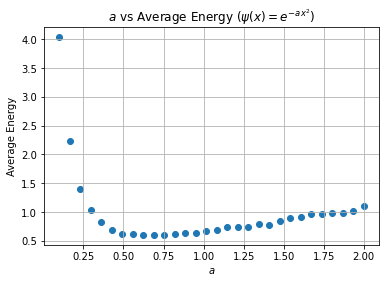

a value with minimum average energy: 0.6847200457564594
min energy: 0.6052293192067907


In [6]:
plt.scatter(a_vals, energies)
plt.title("$a$ vs Average Energy ($\psi(x) = e^{-ax^2}$)")
plt.xlabel("$a$")
plt.ylabel("Average Energy")
plt.grid()
plt.show()
print("a value with minimum average energy: "+ str(a_min))
print("min energy: " + str(avg_energy(10**4, a_min)))